# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  27 November 2023**

# Notebook 5. Reddit dataset - BOW models applied

In this notebook I apply of the logistic regression models trained on the labelled data  towards the previous unseen data from the financial Reddit posts dataset. 

The structure of this book is as follows:

* 5.1. Loading the dataset and the models
* 5.2. Pre-processing the text using the same steps as for the labelled dataset. 
* 5.3. Step 1: the first model (relevant/irrelevnt) is applied, classifyinhg posts as "relevent" (likely containing financial recomemndations or signalling an intent to trade) and "irrelevant" (informational, discussions, etc.)
* 5.4. Step 2: the second (yes/no) model is applied, labelling messages either as bullish or bearish in nature. 
* 5.5. The predictions are analysed chronologically.
* 5.6. The rows are grouped by author, and the patterns of bullishness are analsyed for the most active authors (with >25 posts per year) are analysed. 
* 5.7. Conclusions of the project to date. 
* 5.8. The next steps described. 

## 5.1. Imports

In [125]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import warnings
warnings.filterwarnings("ignore")

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans' 
pd.set_option('display.max_colwidth', None)

In [126]:
df_all = pd.read_csv('../data/reddit_cleaned.csv')

In [127]:
# df_all = df_all.sample(300000).copy()
# df = df_all.copy()

In [128]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103512 entries, 0 to 1103511
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1103512 non-null  object 
 1   author               1103506 non-null  object 
 2   created              1103506 non-null  object 
 3   removed              1103506 non-null  float64
 4   deleted              1103506 non-null  float64
 5   is_self              1103506 non-null  float64
 6   is_video             1103506 non-null  float64
 7   link_flair_text      1103506 non-null  object 
 8   upvote_ratio         1103506 non-null  float64
 9   score                1103506 non-null  float64
 10  num_comments         1103506 non-null  float64
 11  shortlink            1103506 non-null  object 
 12  FolderName           1103506 non-null  object 
 13  word_count_selftext  1103506 non-null  float64
 14  word_count_title     1103506 non-null  float64
 15

In [129]:
# Convert 'Text' column to string
df_all['Text'] = df_all['Text'].astype(str)

# Convert 'date' column to datetime
df_all['date'] = pd.to_datetime(df_all['date'])

# Filter out rows where 'title' starts with 'Daily '
df_all = df_all[~df_all['Text'].str.startswith('Daily ')].copy()
df_all = df_all[~df_all['Text'].str.startswith('Market Events')].copy()

print(df_all.shape)

(1102512, 17)


In [130]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102512 entries, 0 to 1103511
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1102512 non-null  object        
 1   author               1102506 non-null  object        
 2   created              1102506 non-null  object        
 3   removed              1102506 non-null  float64       
 4   deleted              1102506 non-null  float64       
 5   is_self              1102506 non-null  float64       
 6   is_video             1102506 non-null  float64       
 7   link_flair_text      1102506 non-null  object        
 8   upvote_ratio         1102506 non-null  float64       
 9   score                1102506 non-null  float64       
 10  num_comments         1102506 non-null  float64       
 11  shortlink            1102506 non-null  object        
 12  FolderName           1102506 non-null  object        
 13  wo

In [131]:
# Selecting only the 'id', 'title', and 'selftext' columns
#df = df_all[['id', 'Text']].copy()
df = df_all.copy()

In [132]:
df.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,num_comments,shortlink,FolderName,word_count_selftext,word_count_title,date,Text
1103440,l7g8ry,ronfather,2021-01-29 02:13:48,1.00,0.00,1.00,0.00,Discussion,1.00,1.00,0.00,https://redd.it/l7g8ry,wallstreetbets,1.00,22.00,2021-01-29,HOW MANY OF YOU BOUGHT ONLY 1 SHARE OF $GME ? I AM GENUINELY CURIOUS ABOUT THE POWER EVEN ONE SHARE HAS. [removed]


In [133]:
df.shape

(1102512, 17)

## 5.2. Pre-processing for BOW modelling

In [134]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'amc', 'nok', 'bb', "game", 'pltr', 'spy']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [135]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=True):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

## 5.3. Relevant/irrelevant model applied

In [136]:
import joblib
# Load the pipelineon relevance
pipeline_loaded_rel = joblib.load('../model/03_B_best_pipeline_relevance.pkl')

In [137]:
# Predicting new data based on Text

# Assign new X variable 
X_new = df['Text']

# Apply the relevance pipeline to the WSB dataset
predictions_rel = pipeline_loaded_rel.predict(X_new)

In [138]:
# Review and process predictions

pbb_rel = pipeline_loaded_rel.predict_proba(X_new)
df['Probab_not_rel']= pbb_rel[:,0]
df['Probab_yes_rel']= pbb_rel[:,1]
df['Post Relevance'] = predictions_rel

#df.to_csv('../data/05_predictions_relevance.csv', index=False)

In [139]:
df.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,num_comments,shortlink,FolderName,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance
439732,o7pgwf,FuzzyButterscotch918,2021-06-25 15:02:47,1.00,0.00,1.00,0.00,💎 🙌,1.00,1.00,1.00,https://redd.it/o7pgwf,gme,1.00,5.00,2021-06-25,Retarded ape reporting for duty. [removed],0.86,0.14,0


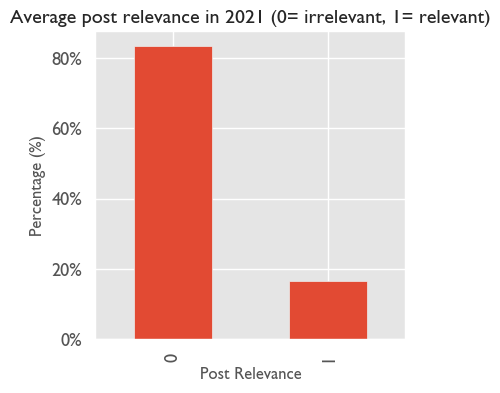

In [140]:
# Calculate the value counts and convert to percentages
value_counts = df['Post Relevance'].value_counts(normalize=True).sort_index() * 100

# Plotting the percentages
ax = value_counts.plot(kind='bar',
                       title='Average post relevance in 2021 (0= irrelevant, 1= relevant)',
                       figsize=(4, 4))

# Set the x-label
ax.set_xlabel('Post Relevance')

# Set the y-label to indicate percentages
ax.set_ylabel('Percentage (%)')

# Optional: Format y-axis ticks as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.show()

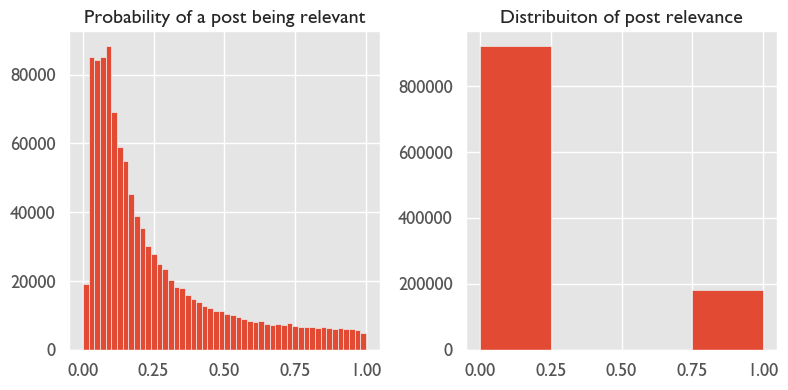

In [141]:
# Plotting the histograms
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Probability of a post being relevant')
plt.hist(df['Probab_yes_rel'], bins=50)

plt.subplot(1, 2, 2)
plt.title('Distribuiton of post relevance')
plt.hist(df['Post Relevance'], bins=4)

plt.tight_layout()
plt.show()


In [142]:
print(pipeline_loaded_rel.named_steps.keys())

# Extract the model from the pipeline
model = pipeline_loaded_rel.steps[-1][1]

# Replace 'correct_step_name' with the actual step name you found
vectorizer = pipeline_loaded_rel.named_steps['tfidf_log']
feature_names = vectorizer.get_feature_names_out()

print(len(model.coef_[0]))
print(len(feature_names))

dict_keys(['tfidf_log', 'logr_log'])
154009
154009


In [143]:
# Extracting model coefficients:
if hasattr(model, 'coef_'):
    # Extract feature names
    vectorizer = pipeline_loaded_rel.named_steps['tfidf_log']  
    feature_names_rel = vectorizer.get_feature_names_out()

    # Storing the coefficients
    coef_df_rel = pd.DataFrame({
        "coefficient": model.coef_[0],
        "token": feature_names
    })

    # Sort by coefficients
    coef_df_rel = coef_df_rel.sort_values("coefficient", ascending=False)

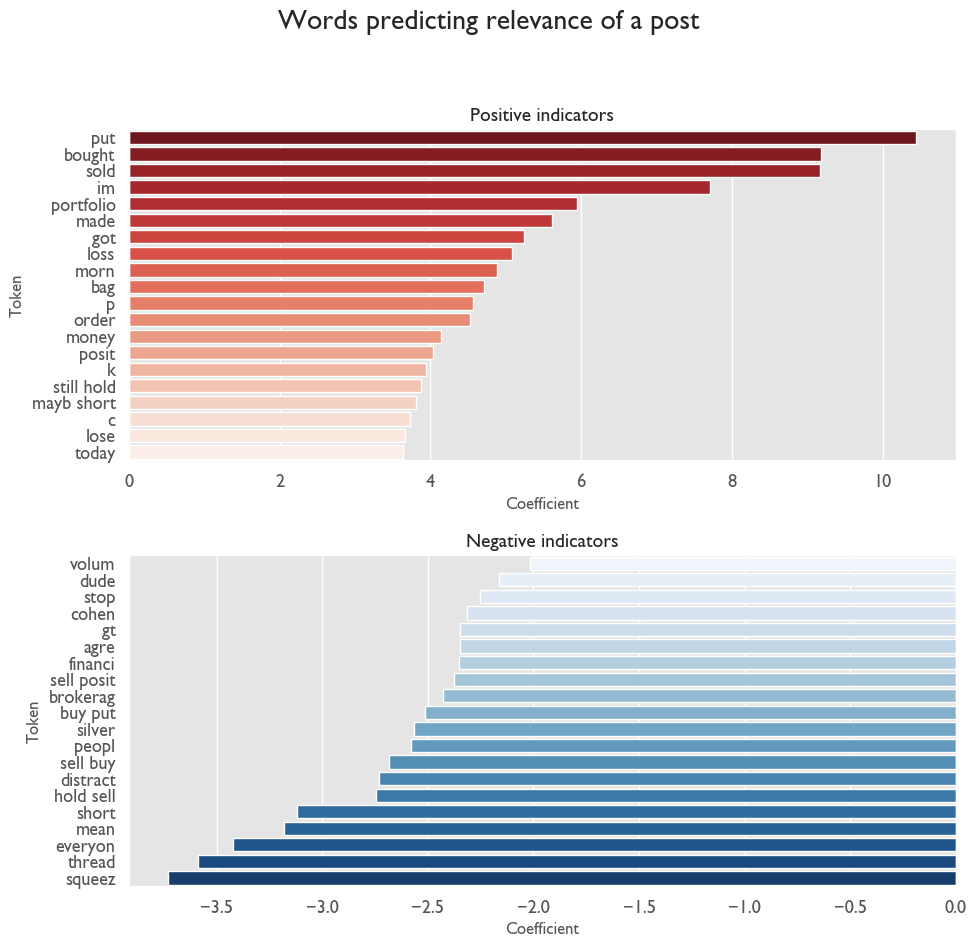

In [144]:
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Setting the overall figure title with a specific font
    fig.suptitle('Words predicting relevance of a post', fontsize=20, fontname='Gill Sans')

    # Setting up the Seaborn style
    sns.set(style="whitegrid", font_scale=1.2)

    # Plot tokens with largest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df_rel.head(20), ax=axs[0], palette="Reds_r")
    axs[0].set_title("Positive indicators", fontsize=14)
    axs[0].set_xlabel("Coefficient")
    axs[0].set_ylabel("Token")

    # Plot tokens with smallest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df_rel.tail(20), ax=axs[1], palette="Blues")
    axs[1].set_title("Negative indicators", fontsize=14)
    axs[1].set_xlabel("Coefficient")
    axs[1].set_ylabel("Token")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 

    plt.show()

## 5.4. Buy / Sell Model applied

In [145]:
# Load the entire pipeline from the file
pipeline_loaded = joblib.load('../model/03_A_best_pipeline_yes_no.pkl')

In [146]:
# Predicting BUY and SELL sentiment 
# Apply the pipeline to the WSB dataset
predictions = pipeline_loaded.predict(X_new)

In [147]:
# Review and process BUY and SELL predictions 

pbb = pipeline_loaded.predict_proba(X_new)
df['Prob SELL']= pbb[:,0]
df['Prob BUY']= pbb[:,1]
df['BUY SELL categories'] = predictions

#df.to_csv('../data/05_predictions_yes_no.csv', index=False)

In [148]:
df.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
707632,m47f6q,DefendtheStarLeague,2021-03-13 14:33:37,1.00,0.00,0.00,0.00,Meme,1.00,1.00,...,1.00,8.00,2021-03-13,You're a shill and we are the cure nan,0.82,0.18,0,0.93,0.07,0


In [149]:
relevant = df[df['Probab_yes_rel'] > 0.5]
relevant.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
380936,mgsll1,ninety9problms,2021-03-30 23:14:44,1.00,0.00,0.00,1.00,Meme,0.94,33.00,...,1.00,10.00,2021-03-30,Archived video of Nomura CS giving ACM their margin leverage nan,0.30,0.70,1,0.06,0.94,1


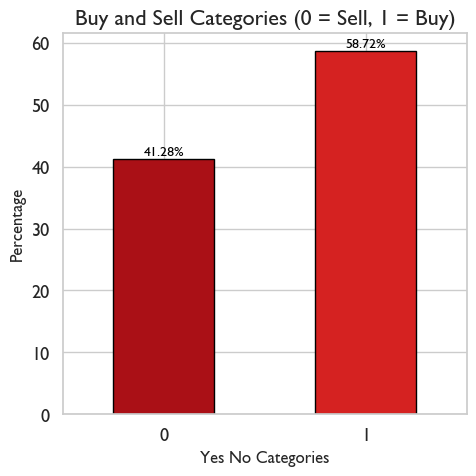

In [150]:
plt.rcParams['font.family'] = 'Gill Sans'

# Calculate the percentage values
total_count = len(relevant)
percentages = relevant['BUY SELL categories'].value_counts(normalize=True).sort_index() * 100

# plot the data 
ax = percentages.plot(kind='bar',
                      color=sns.color_palette("Reds_r"),
                      edgecolor='black',
                      figsize=(5, 5))

ax.set_title('Buy and Sell Categories (0 = Sell, 1 = Buy)', fontsize=16)
ax.set_xlabel('Yes No Categories', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)

ax.tick_params(axis='x', labelrotation=0)

# Annotate the bars with percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

## 5.5. Analysing the predictions

In [151]:
buys = relevant[relevant['Prob BUY'] > 0.5]
buys.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
218808,mih5h9,MikeWithBike,2021-04-02 09:58:03,0.00,0.00,0.00,0.00,Discussion 🦍,1.00,13.00,...,1.00,7.00,2021-04-02,And what are your actions for today? nan,0.49,0.51,1,0.27,0.73,1


In [152]:
# Examining the SELL recommendations
sells = relevant[relevant['Prob BUY'] < 0.5]
sells.sample(1)

,id,author,created,removed,deleted,is_self,is_video,link_flair_text,upvote_ratio,score,...,word_count_selftext,word_count_title,date,Text,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
590564,r5v6vj,[deleted],2021-11-30 19:26:44,1.00,1.00,0.00,0.00,Meme,1.00,1.00,...,1.00,6.00,2021-11-30,Where can i buy Verstappen puts? [deleted],0.05,0.95,1,0.66,0.34,0


### Extracting model coefficients from the pickled model

In [153]:
print(pipeline_loaded.named_steps.keys())

# Extract the model from the pipeline
model = pipeline_loaded.steps[-1][1]

# Replace 'correct_step_name' with the actual step name you found
vectorizer = pipeline_loaded.named_steps['tfidf_log']
feature_names = vectorizer.get_feature_names_out()

print(len(model.coef_[0]))
print(len(feature_names))

dict_keys(['tfidf_log', 'logr_log'])
32985
32985


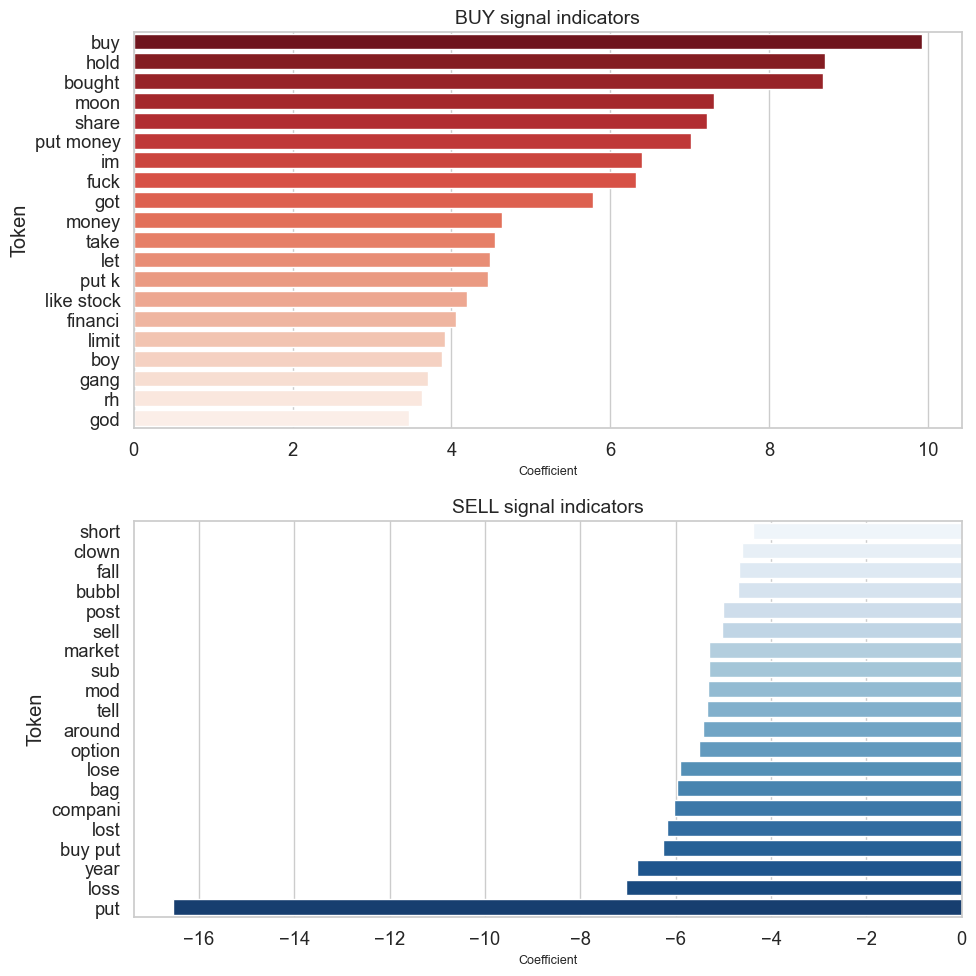

In [154]:
if hasattr(model, 'coef_'):
    # Extract feature names
    vectorizer = pipeline_loaded.named_steps['tfidf_log']  
    feature_names = vectorizer.get_feature_names_out()

    # Storing the coefficients
    coef_df = pd.DataFrame({
        "coefficient": model.coef_[0],
        "token": feature_names
    })

    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Setting up the Seaborn style
    sns.set(style="whitegrid", font_scale=1.2)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot tokens with smallest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df.head(20), ax=axs[0], palette="Reds_r")
    axs[0].set_title("BUY signal indicators", fontsize=14)
    axs[0].set_xlabel("Coefficient",fontsize=9)
    axs[0].set_ylabel("Token")

    # Plot tokens with largest coefficients
    sns.barplot(x="coefficient", y="token", data=coef_df.tail(20), ax=axs[1], palette="Blues")
    axs[1].set_title("SELL signal indicators", fontsize=14)
    axs[1].set_xlabel("Coefficient", fontsize=9)
    axs[1].set_ylabel("Token")

    fig.tight_layout()
    plt.show()
else:
    print("The model does not have coefficients to extract.")


In [155]:
#df.to_csv('../data/05_Reddit_model_applied_results.csv', index=False)

## 5.6. Grouping by author

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102512 entries, 0 to 1103511
Data columns (total 23 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1102512 non-null  object        
 1   author               1102506 non-null  object        
 2   created              1102506 non-null  object        
 3   removed              1102506 non-null  float64       
 4   deleted              1102506 non-null  float64       
 5   is_self              1102506 non-null  float64       
 6   is_video             1102506 non-null  float64       
 7   link_flair_text      1102506 non-null  object        
 8   upvote_ratio         1102506 non-null  float64       
 9   score                1102506 non-null  float64       
 10  num_comments         1102506 non-null  float64       
 11  shortlink            1102506 non-null  object        
 12  FolderName           1102506 non-null  object        
 13  wo

In [157]:
# Excluding object columns and aggregating by day
df_numerical = df.select_dtypes(include=[np.number])

# Grouping by day and averaging numerical columns
df_agg_by_day = df_numerical.groupby(df['date'].dt.date).mean()
df_agg_by_day.head() 

,removed,deleted,is_self,is_video,upvote_ratio,score,num_comments,word_count_selftext,word_count_title,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
date,,,,,,,,,,,,,,,
2021-01-01,0.72,0.21,0.64,0.03,0.86,90.76,53.47,36.59,9.80,0.67,0.33,0.25,0.47,0.53,0.52
2021-01-02,0.74,0.17,0.66,0.03,0.87,102.50,17.16,44.30,8.58,0.71,0.29,0.20,0.48,0.52,0.52
2021-01-03,0.74,0.16,0.68,0.03,0.86,138.03,16.42,59.82,8.66,0.69,0.31,0.22,0.49,0.51,0.51
2021-01-04,0.77,0.17,0.65,0.03,0.88,68.71,11.20,30.24,8.72,0.70,0.30,0.22,0.46,0.54,0.56
2021-01-05,0.73,0.16,0.67,0.03,0.88,57.30,13.08,31.86,8.53,0.70,0.30,0.20,0.46,0.54,0.56


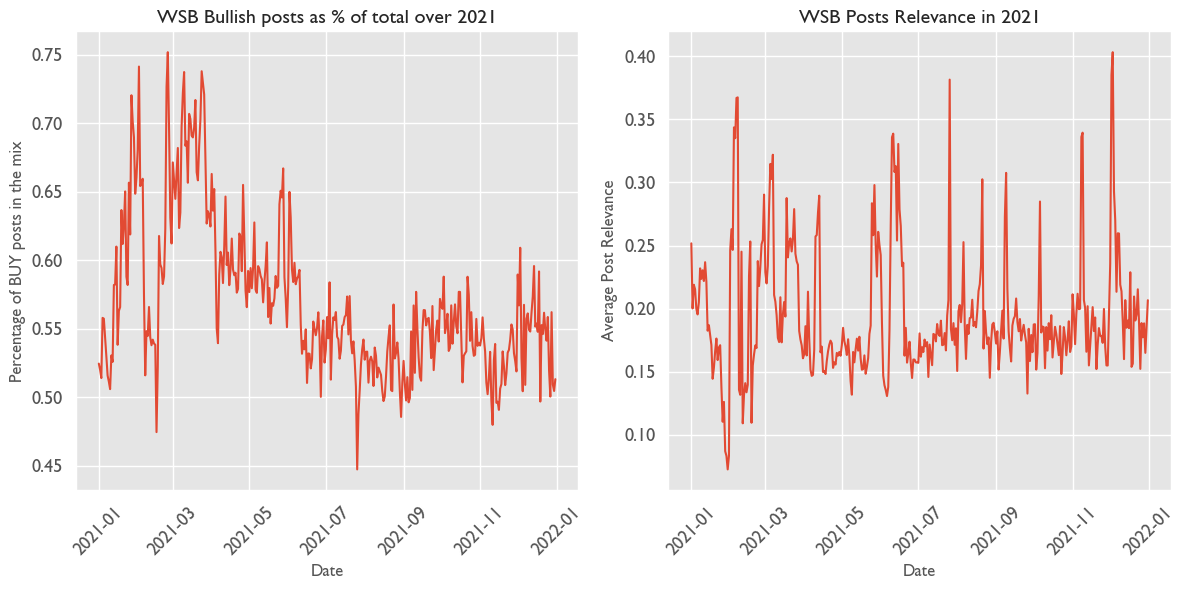

In [158]:
# Plotting average level of bullishness in 2021. Average percentage of relevant posts daily in 2021 

# Set visualization and pandas display options
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the global font to be used for all text
plt.rcParams['font.family'] = 'Gill Sans'  


# Setting up the figure for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting each field in a separate subplot
sns.lineplot(ax=axes[0], data=df_agg_by_day, x=df_agg_by_day.index, y='BUY SELL categories')
axes[0].set_title('WSB Bullish posts as % of total over 2021')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Percentage of BUY posts in the mix')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(ax=axes[1], data=df_agg_by_day, x=df_agg_by_day.index, y='Post Relevance')
axes[1].set_title('WSB Posts Relevance in 2021')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Post Relevance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [159]:
# Group by the 'author' column and aggregate other columns
df_agg_by_author = df.groupby([df['author']]).agg({
    'id':'count', 
    'score': 'mean',
    'num_comments':'sum',
    'deleted':'sum',
    'removed':'sum',
    'upvote_ratio':'sum',
    'Probab_not_rel':'mean',
    'Probab_yes_rel':'mean',
    'Post Relevance':'mean',
    'Prob SELL':'mean',
    'Prob BUY':'mean',
    'BUY SELL categories':'mean'
    #'word_count':'mean'
}).reset_index().rename(columns={
    'id': 'total_posts',
    'score': 'average_score',
    'num_comments': 'total_comments',
    'deleted':'total_deleted',
    'removed':'total_removed',
    'upvote_ratio':'total_upvote_ratio',
    'Probab_not_rel':'aver prob irrel',
    'Probab_yes_rel':'aver prob relev',
    'Post Relevance':'percent relevant',
    'Prob SELL':'aver prob SELL',
    'Prob BUY':'aver prob BUY',
    'BUY SELL categories':'Aver bullishness'
    #'word_count':'aver word count'
})

In [190]:
# Filter the dataframe to show the authors with the highest score
df_agg_by_author_sorted = df_agg_by_author.sort_values(by='average_score', ascending=False)

# Filter to include rows where 'total_posts' > 10
df_agg_by_author_sorted_filtered = df_agg_by_author_sorted[df_agg_by_author_sorted['total_posts'] > 25].sort_values(by='percent relevant', ascending=False)

# Display the first 20 rows of the filtered DataFrame
df_agg_by_author_sorted_filtered.head(10)


,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness
4865,628rand,35,5.09,47.00,0.00,0.00,28.12,0.22,0.78,1.00,0.74,0.26,0.00
130127,Joe_A1,40,1.95,124.00,0.00,1.00,26.92,0.19,0.81,0.97,0.54,0.46,0.40
209814,RepinskiUK,29,44.48,878.00,0.00,0.00,25.71,0.22,0.78,0.97,0.93,0.07,0.00
382509,moo2467,26,4.00,126.00,0.00,7.00,18.84,0.06,0.94,0.96,0.03,0.97,0.96
1190,0toHeroInvesting,43,136.47,2025.00,0.00,2.00,36.65,0.06,0.94,0.95,0.99,0.01,0.00
90011,FireMaster1294,38,13.34,231.00,0.00,1.00,34.67,0.37,0.63,0.95,0.49,0.51,0.58
400312,psychotrader00,243,34.24,1565.00,0.00,13.00,223.64,0.12,0.88,0.94,0.98,0.02,0.00
123829,Itsboomhomie,154,24.92,913.00,0.00,12.00,141.16,0.09,0.91,0.92,0.89,0.11,0.08
308526,cclagator,57,131.28,2856.00,0.00,0.00,51.60,0.33,0.67,0.91,0.97,0.03,0.00
219942,SavannahSmiles_,31,7.32,154.00,0.00,0.00,21.91,0.22,0.78,0.87,0.95,0.05,0.03


In [191]:
df_agg_by_author_sorted_filtered.shape

(1864, 13)

In [192]:
df_agg_by_author_sorted_filtered.describe()

,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness
count,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00,1864.00
mean,135.04,167.06,1176.51,54.99,99.34,120.57,0.68,0.32,0.23,0.41,0.59,0.62
std,3735.01,598.60,15256.31,2374.06,3725.36,3390.36,0.11,0.11,0.16,0.18,0.18,0.23
min,26.00,0.39,0.00,0.00,0.00,15.32,0.06,0.06,0.00,0.03,0.01,0.00
25%,30.00,19.66,203.00,0.00,3.00,25.65,0.63,0.24,0.11,0.28,0.50,0.50
50%,36.00,55.29,389.00,0.00,6.00,31.66,0.71,0.29,0.19,0.36,0.64,0.69
75%,51.00,138.10,835.50,0.00,16.00,43.67,0.76,0.37,0.30,0.50,0.72,0.79
max,161292.00,17140.13,654904.00,102498.00,160846.00,146406.54,0.94,0.94,1.00,0.99,0.97,1.00


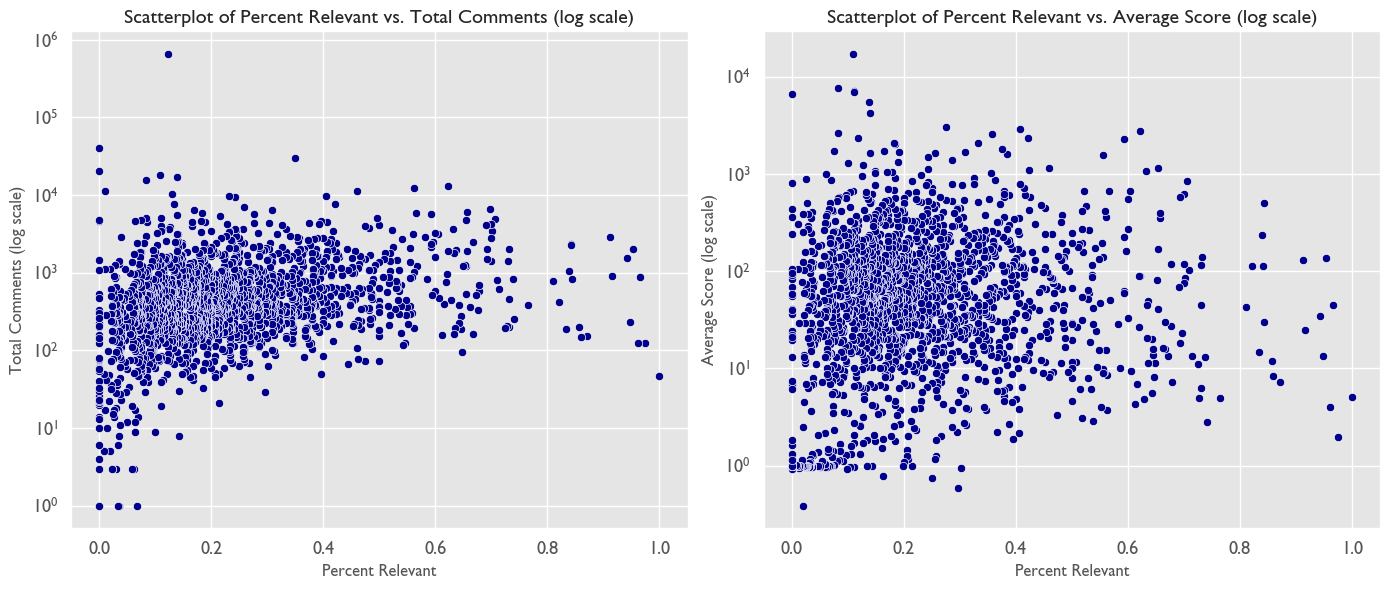

In [193]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_color = 'darkblue'

# First scatterplot
sns.scatterplot(data=df_agg_by_author_sorted_filtered, x='percent relevant', y='total_comments', ax=axes[0], color=plot_color)
axes[0].set_yscale('log')
axes[0].set_title('Scatterplot of Percent Relevant vs. Total Comments (log scale)')
axes[0].set_xlabel('Percent Relevant')
axes[0].set_ylabel('Total Comments (log scale)')

# Second scatterplot
sns.scatterplot(data=df_agg_by_author_sorted_filtered, x='percent relevant', y='average_score', ax=axes[1], color=plot_color)
axes[1].set_yscale('log')
axes[1].set_title('Scatterplot of Percent Relevant vs. Average Score (log scale)')
axes[1].set_xlabel('Percent Relevant')
axes[1].set_ylabel('Average Score (log scale)')

plt.tight_layout()
plt.show()


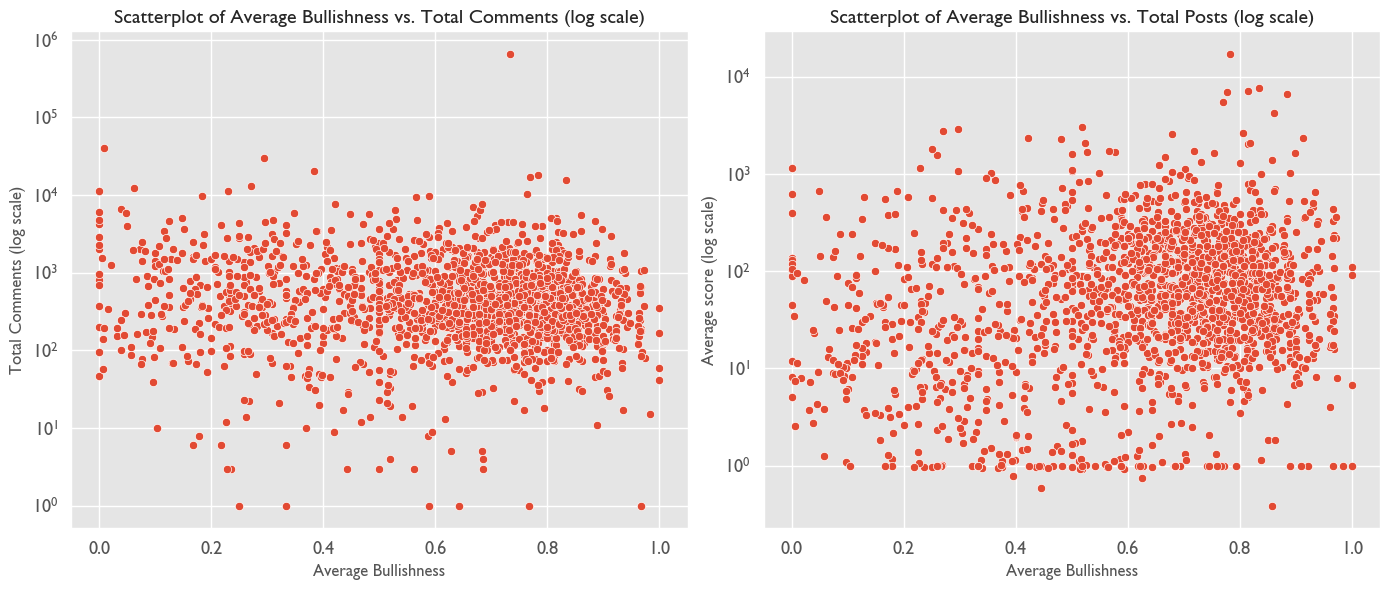

In [194]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First scatterplot
sns.scatterplot(data=df_agg_by_author_sorted_filtered, x='Aver bullishness', y='total_comments', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Scatterplot of Average Bullishness vs. Total Comments (log scale)')
axes[0].set_xlabel('Average Bullishness')
axes[0].set_ylabel('Total Comments (log scale)')

# Second scatterplot
sns.scatterplot(data=df_agg_by_author_sorted_filtered, x='Aver bullishness', y='average_score', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Scatterplot of Average Bullishness vs. Total Posts (log scale)')
axes[1].set_xlabel('Average Bullishness')
axes[1].set_ylabel('Average score (log scale)')

plt.tight_layout()
plt.show()


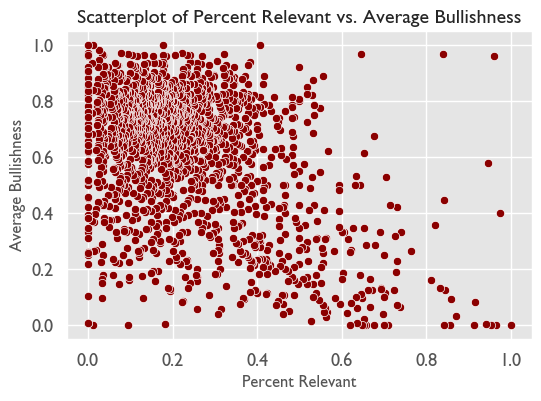

In [195]:
# Bullishness vs relevance plot

plot_color = 'darkred'
sns.scatterplot(data=df_agg_by_author_sorted_filtered, x='percent relevant', y='Aver bullishness', color=plot_color)
plt.title('Scatterplot of Percent Relevant vs. Average Bullishness')
plt.xlabel('Percent Relevant')
plt.ylabel('Average Bullishness')
plt.show()


In [189]:
# Sorting the filtering results by the AVERAGE SCORE
df_agg_by_author_sorted['total_pct_removed'] = df_agg_by_author_sorted['total_removed'] / df_agg_by_author['total_posts'] *100

df_authors= df_agg_by_author_sorted.sort_values(by='total_pct_removed', ascending=False).head(100)
df_authors.head(10)


,author,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness,total_pct_removed
343987,henny669,1,1.00,0.00,0.00,1.00,1.00,0.73,0.27,0.00,0.06,0.94,1.00,100.00
133475,Juststellar,4,1.00,1.00,0.00,4.00,4.00,0.48,0.52,0.75,0.76,0.24,0.25,100.00
133481,Justtryinganything,1,1.00,1.00,0.00,1.00,1.00,0.90,0.10,0.00,0.65,0.35,0.00,100.00
133482,Justtrynagetrichtoo,1,1.00,0.00,0.00,1.00,1.00,0.88,0.12,0.00,0.16,0.84,1.00,100.00
133483,Justtrynamakeit95,1,1.00,0.00,0.00,1.00,1.00,0.86,0.14,0.00,0.10,0.90,1.00,100.00
133484,Justtrynamakeit98,1,1.00,2.00,0.00,1.00,1.00,0.97,0.03,0.00,0.66,0.34,0.00,100.00
133486,Justuraveragejim,2,1.00,2.00,0.00,2.00,2.00,0.75,0.25,0.00,0.75,0.25,0.00,100.00
133488,Justvibingbro94,1,1.00,0.00,0.00,1.00,1.00,0.97,0.03,0.00,0.66,0.34,0.00,100.00
133490,Justwaitingonmymoney,3,1.00,5.00,0.00,3.00,3.00,0.91,0.09,0.00,0.54,0.46,0.33,100.00
133491,Justwanttosavebuddy,1,1.00,0.00,0.00,1.00,1.00,0.96,0.04,0.00,0.50,0.50,1.00,100.00


Seeing a lot of bots, where 100% of their posts have been deleted by the moderators. I want to drop those spammers from my analysis. The code below shows that 63.6% of authors were actually spammers. This leaves me with a substantially smaller number of authors (163,768).

In [175]:
df_agg_by_author.describe()

,total_posts,average_score,total_comments,total_deleted,total_removed,total_upvote_ratio,aver prob irrel,aver prob relev,percent relevant,aver prob SELL,aver prob BUY,Aver bullishness
count,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00,451458.00
mean,2.44,66.27,27.64,0.23,1.72,2.21,0.77,0.23,0.14,0.41,0.59,0.60
std,240.10,1184.54,1382.20,152.55,239.40,217.94,0.21,0.21,0.31,0.28,0.28,0.45
min,1.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,0.00,0.00,1.00,1.00,0.68,0.08,0.00,0.17,0.34,0.00
50%,1.00,1.00,1.00,0.00,1.00,1.00,0.84,0.16,0.00,0.39,0.61,0.89
75%,2.00,4.50,6.00,0.00,1.00,1.96,0.92,0.32,0.00,0.66,0.83,1.00
max,161292.00,204095.00,654904.00,102498.00,160846.00,146406.54,1.00,1.00,1.00,1.00,1.00,1.00


## 5.7. Conclusions after predicting the unseen data

The main conclusions after this exercise can be summarise as follows:

* I applied the models trained on labelled data on previously unseen data.  The resulting labels and their probabilities have been recorded in new numerical columns. 

* The new valuable information allowed me to start measuring the overall bullishness/bearishness of the posts, chronologically and by author over a certain period.

* While I cannot measure the accuracy of the model once it was applied to this new unseen dataset, as I have no labels, I can use some other check to evaluate usefulness of this approach.  The overall trends in the community bullishness/bearishness, as predicted by my 2-step approach, agree with the actual events that happened on the markets in that period of time. I have reviewed some of the previous applications of naive sentiment analysis to the WallStreetBets messages made by other researchers.  They generally did not manage to fine any particular pattern in the sentiment in 2021. I am quite pleased with the result of my 2-step modelling approach and its validity is indirectly confirmed by its ability to spot the actual trends in sentiment.

* We can see that 80% of the posts don’t contain any recommendation to buy or sell.  80% of the posts are general discussions (also can be useful), meme postings, video postings, etc.   

* We can see that on the aggregate level, if we zoom into those 20% of the posts that are predicted to contain bullish or bearish views, 60% of the posts were bullish and 40% were bearish, over 2021.

* Looking at the chronological distribution of bullishness over time, we can see a clear pick up in bullishness of 1Q 2021, and then a stable level over the rest of 2021.  This agrees with the actual events on the markets. The short squeeze was over, and the bullishness subsided, together with the GameStop share price.

* Aggregating the bullishness indicator by author also yields some interesting results. We can now cluster the authors by how relevant their messages were on average in 2021.  This can be helpful in reducing informational noise.

* Overall, plotting bullishness vs relevance, I can see that most authors in 2021 were very bullish and not very relevant! :)  

* Focusing on a small select group of the authors that posted more than 25 messages per year (the active contributors posting at least every other week) we can see that the level of engagement their posts received was not correlated to the bullishness of their messages. The level of comments each author received does not seem to depend on the level of the author's bullishness.  However, we can see clear clustering in that group, with majority of the authors actually being consistently bullish (bullish 70-80% of the time).  We can investigate this angle deeper and try to define more precisely this cluster of "all season bulls" (not very helpful in the markets). 

* Having this new aggregate information on relevance and bullishness by each author allows us to create a filter and only focus on reading only those messages where the author demonstrated a reasonable level of bullishness and a high degree of relevance in his/her posts.  This is a very useful tool that helps to reduce noise to signal ration for investors.

## 5.8. The next steps


As a next step in this project, I am planning to do the following:

1. Build predictive models that focus on a sentence level embeddings, not only on the simple bag of words approach.  I already started this work, and I can see that the accuracy and precision of the models built using Gensim, spaCy and BERT embeddings is higher than the traditional BoW approach I explored so far.  It will be interesting to compare the final classification results of these two approaches, to understand their strengths and weaknesses.

2. After doing this step and selecting the best available predictive approach, perhaps a combination of several models (?), I will perform a back testing of the financial predictions issued by the various WallStreetBets authors/accounts in 2021. This will allow me to evaluate the quality of the authors financial skills. 

3. I am also planning to perform a clustering analysis of various actively posting authors, using additionally feature engineering, for example, rating their posts based on the language complexity, readability index, number of words per sentence, etc.  This will be another useful exercise in my attempt to decipher whose accounts are worth following on social media focused on financial markets. 